In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
import tensorflow as tf
from tqdm import trange
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import math
import random
import copy

In [46]:
df = pd.read_csv("./data.csv")

In [47]:
df = df.rename(columns={"tension_strenght": "tensile_strength"})

In [48]:
df

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7
5,0.02,10,40,honeycomb,200,60,40,pla,0,60,24,1.1
6,0.02,5,10,grid,205,65,40,pla,25,55,12,1.3
7,0.02,10,10,honeycomb,210,70,40,pla,50,21,14,1.5
8,0.02,9,70,grid,215,75,40,pla,75,24,27,1.4
9,0.02,8,40,honeycomb,220,80,40,pla,100,30,25,1.7


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   layer_height        50 non-null     float64
 1   wall_thickness      50 non-null     int64  
 2   infill_density      50 non-null     int64  
 3   infill_pattern      50 non-null     object 
 4   nozzle_temperature  50 non-null     int64  
 5   bed_temperature     50 non-null     int64  
 6   print_speed         50 non-null     int64  
 7   material            50 non-null     object 
 8   fan_speed           50 non-null     int64  
 9   roughness           50 non-null     int64  
 10  tensile_strength    50 non-null     int64  
 11  elongation          50 non-null     float64
dtypes: float64(2), int64(8), object(2)
memory usage: 4.8+ KB


In [50]:
df.infill_pattern.value_counts()

infill_pattern
grid         25
honeycomb    25
Name: count, dtype: int64

In [51]:
df.material.value_counts()

material
abs    25
pla    25
Name: count, dtype: int64

In [52]:
for column in df.columns:
    print(str(column)+": "+str(df[column].unique()))
    print()

layer_height: [0.02 0.06 0.1  0.15 0.2 ]

wall_thickness: [ 8  7  1  4  6 10  5  9  2  3]

infill_density: [90 80 70 40 10 20 50 30 60]

infill_pattern: ['grid' 'honeycomb']

nozzle_temperature: [220 225 230 240 250 200 205 210 215]

bed_temperature: [60 65 70 75 80]

print_speed: [ 40  60 120]

material: ['abs' 'pla']

fan_speed: [  0  25  50  75 100]

roughness: [ 25  32  40  68  92  60  55  21  24  30  75 118 200 220 126 145  88  74
 120 144 265 312 368 180 176 128 138 121 168 154 225 289 326 192 212 172
 163 276 298 360 357 321 278 244]

tensile_strength: [18 16  8 10  5 24 12 14 27 25 37  9 23 26 33 29 19 11 34 13 22  4 35 28
 21 30]

elongation: [1.2 1.4 0.8 0.5 0.7 1.1 1.3 1.5 1.7 2.4 1.  2.2 1.9 1.6 2.1 2.  0.9 0.4
 1.8 2.9 0.6 2.8 2.3 3.3 3.1 2.7 3.2]



In [53]:
#In this data set, ABS and PLA assigned 0 and 1 values for materials (abs = 0, pla = 1)
df.material = [0 if each=='abs' else 1 for each in df.material]

#In this data set, grid and honeycomb assigned 0 and 1 values for infill_pattern (grid = 0, honeycomb = 1)
df.infill_pattern = [0 if each=='grid' else 1 for each in df.infill_pattern]

df.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,0.02,8,90,0,220,60,40,0,0,25,18,1.2
1,0.02,7,90,1,225,65,40,0,25,32,16,1.4
2,0.02,1,80,0,230,70,40,0,50,40,8,0.8
3,0.02,4,70,1,240,75,40,0,75,68,10,0.5
4,0.02,6,90,0,250,80,40,0,100,92,5,0.7


In [54]:
df.layer_height = df.layer_height*100
df.elongation = df.elongation*100

In [55]:
target_cols = ['tensile_strength', 'roughness', 'elongation']
y = df[target_cols].values
x = df.drop(target_cols,axis=1).values

<Axes: xlabel='fan_speed', ylabel='tensile_strength'>

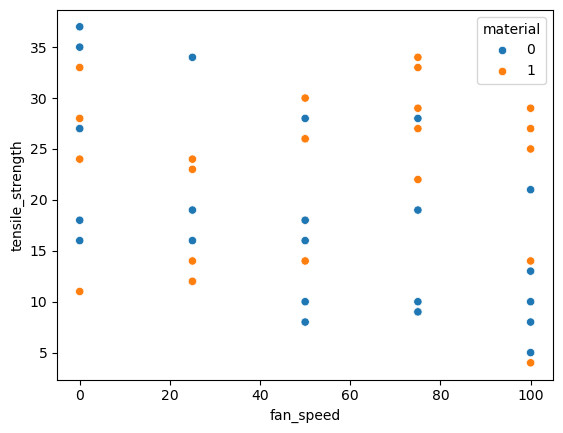

In [56]:
sns.scatterplot(x=df.fan_speed,y=df.tensile_strength,hue=df.material)

<Axes: xlabel='layer_height', ylabel='roughness'>

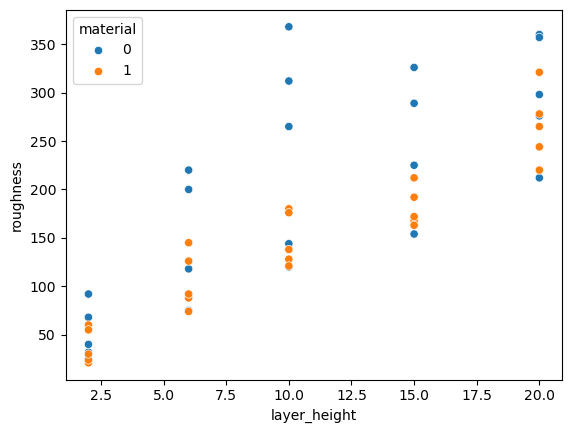

In [57]:
sns.scatterplot(x=df.layer_height,y=df.roughness,hue=df.material)

<Axes: xlabel='infill_pattern', ylabel='elongation'>

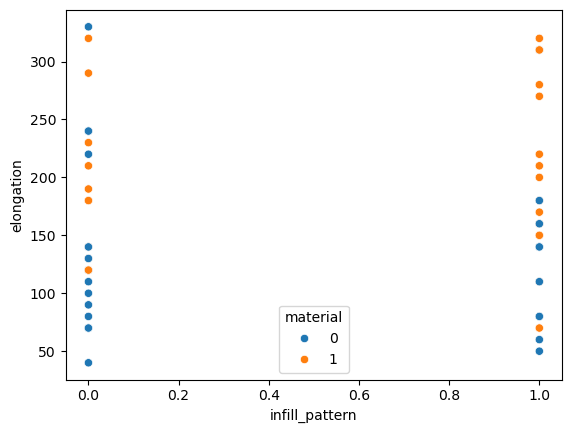

In [58]:
sns.scatterplot(x=df.infill_pattern,y=df.elongation,hue=df.material)

<Axes: xlabel='nozzle_temperature', ylabel='roughness'>

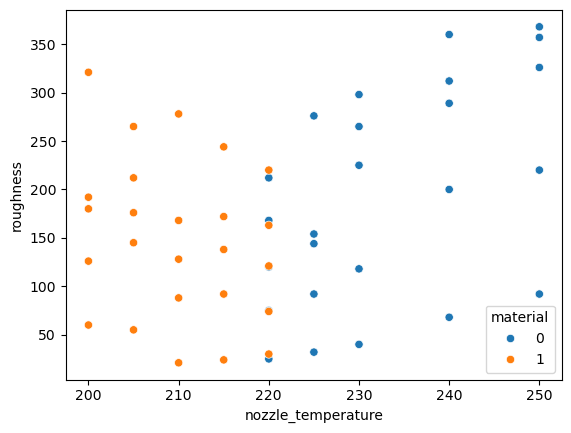

In [59]:
sns.scatterplot(x=df.nozzle_temperature,y=df.roughness,hue=df.material)

In [60]:


# Move to GPU if available
device = torch.device("cpu" )

x = torch.tensor(x, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

In [61]:
def strength_loss(output, y):
    criterion = nn.MSELoss()
    return criterion(output[:, 0], y[:, 0])

def rough_loss(output, y):
    criterion = nn.MSELoss()
    return criterion(output[:, 1], y[:, 1])  # Fix: return computed loss

def elongation_loss(output, y):
    criterion = nn.MSELoss()
    return criterion(output[:, 2], y[:, 2])  # Fix: return computed loss


In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Assume x and y are already defined
# Example of defining x and y (for illustration)
# x = np.random.rand(100, 9)  # 100 samples, 9 features
# y = np.random.rand(100, 3)  # 100 samples, 3 target values

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Normalize the data using StandardScaler
scaler_x = StandardScaler()
x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Convert the data to PyTorch tensors (no need to use .cuda() for CPU)
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create DataLoader
train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=8, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=8, shuffle=False)




In [63]:
# Define a simple neural network for regression
class DNNRegressor(nn.Module):
    def __init__(self):
        super(DNNRegressor, self).__init__()
        self.fc1 = nn.Linear(9, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 3)  # Output layer (3 outputs for the targets)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


model = DNNRegressor()
criterion = nn.MSELoss()

In [64]:
''' 
NSGA start here
'''
def index_locator(a,list):
    for i in range(0,len(list)):
        if list[i] == a:
            return i
    return -1

In [65]:
def sort_by_values(list1, values):
    sorted_list = []
    while(len(sorted_list)!=len(list1)):
        if index_locator(min(values),values) in list1:  # maximize problem, find the min
            sorted_list.append(index_locator(min(values),values))
        values[index_locator(min(values),values)] = math.inf
    return sorted_list

In [66]:
def non_dominated_sorting(values1, values2, values3):
    num_points = len(values1)
    S = [[] for _ in range(num_points)]
    front = [[]]
    n = [0] * num_points
    rank = [0] * num_points

    for p in range(num_points):
        S[p] = []
        n[p] = 0
        for q in range(num_points):
            if (
                (values1[p] < values1[q] and values2[p] < values2[q] and values3[p] < values3[q]) or
                (values1[p] <= values1[q] and values2[p] < values2[q] and values3[p] < values3[q]) or
                (values1[p] < values1[q] and values2[p] <= values2[q] and values3[p] < values3[q]) or
                (values1[p] < values1[q] and values2[p] < values2[q] and values3[p] <= values3[q])
            ):
                if q not in S[p]:
                    S[p].append(q)
            elif (
                (values1[q] < values1[p] and values2[q] < values2[p] and values3[q] < values3[p]) or
                (values1[q] <= values1[p] and values2[q] < values2[p] and values3[q] < values3[p]) or
                (values1[q] < values1[p] and values2[q] <= values2[p] and values3[q] < values3[p]) or
                (values1[q] < values1[p] and values2[q] < values2[p] and values3[q] <= values3[p])
            ):
                n[p] += 1
        
        if n[p] == 0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

    i = 0
    while front[i]:
        Q = []
        for p in front[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    if q not in Q:
                        Q.append(q)
        i += 1
        front.append(Q)

    del front[-1]  # Remove last empty front
    return front


In [67]:


def crowding_distance(values_list, front):
    # Initialize the distance array
    distance = [0 for _ in range(len(front))]
    
    # Number of objectives
    num_objectives = len(values_list)
    
    # For each objective (each list in values_list)
    for j in range(num_objectives):
        # Sort individuals by objective j
        sorted_individuals = sort_by_values(front, values_list[j][:])
        
        # First and last individual get infinite crowding distance
        distance[0] = math.inf
        distance[-1] = math.inf
        
        # Calculate crowding distance for each individual
        for k in range(1, len(front) - 1):
            distance[k] += (values_list[j][sorted_individuals[k + 1]] - values_list[j][sorted_individuals[k - 1]]) / (max(values_list[j]) - min(values_list[j]))
    
    return distance


In [68]:
def front_value(front,num):  #[[num,x],[]]
  for i in front: 
    for a in i:
      if a == num:
        return front.index(i)

In [69]:
def crowding_distance_value(num,front,crowding_distance):
  index = []
  for i in front:
    for a in i:
      if a == num:
        index = [front.index(i),i.index(a)]
 
  
  result = crowding_distance[index[0]][index[1]]
  return result

In [70]:
def crossover(parent1, parent2, crossover_rate=0.5):
    """
    Performs crossover between two MLP parents.
    """
    child1 = copy.deepcopy(parent1)
    child2 = copy.deepcopy(parent2)
    
    for (p1, p2, c1, c2) in zip(parent1.parameters(), parent2.parameters(), child1.parameters(), child2.parameters()):
        if len(p1.shape) > 1:  # Only perform crossover on weight matrices, not biases
            mask = torch.rand_like(p1) < crossover_rate  # Generate a binary mask
            c1.data[mask] = p2.data[mask]  # Swap weights
            c2.data[mask] = p1.data[mask]
    
    return child1, child2

def mutate(model, mutation_rate=0.1, mutation_strength=0.05):
    """
    Applies mutation to a model by adding Gaussian noise.
    """
    mutated_model = copy.deepcopy(model)
    
    for param in mutated_model.parameters():
        if torch.rand(1).item() < mutation_rate:
            noise = torch.randn_like(param) * mutation_strength
            param.data += noise  # Apply mutation
    
    return mutated_model

In [71]:
def strength_loss(model):
   
    output = model(x)
    return criterion(output[:, 0], y[:, 0])

def rough_loss(model):
    
    output = model(x)
    return criterion(output[:, 1], y[:, 1])  # Fix: return computed loss

def elongation_loss(model):
    
    output = model(x)
    return criterion(output[:, 2], y[:, 2])  # Fix: return computed loss

In [72]:

pop_size = 4
max_gen = 4
gen_no = 0
solution = []
solution_index = []


loss_history = []

for i in range (0,pop_size):
  solution.append(DNNRegressor())

for _ in solution:
  solution_index.append(solution.index(_))

while(gen_no<max_gen):
  objective1_values = [strength_loss(solution[i]) for i in range (0,pop_size)]
  objective2_values = [rough_loss(solution[i]) for i in range (0,pop_size)]
  objective3_values = [elongation_loss(solution[i]) for i in range (0,pop_size)] 

  non_dominated_sorted_solution = non_dominated_sorting(objective1_values[:],objective2_values[:], objective3_values[:])
  print("Generation:",gen_no)
  print(non_dominated_sorted_solution)

  crowding_distance_values=[]
  for i in range(0,len(non_dominated_sorted_solution)):
    crowding_distance_values.append(crowding_distance([objective1_values, objective2_values, objective3_values], non_dominated_sorted_solution[i][:]))
  print(crowding_distance_values)
  #Pareto_front_plotter(objective1_values,objective2_values,non_dominated_sorted_solution)

  solution2 = solution[:]
  while (len(solution2) != 2* pop_size):
   a1 = random.randint(0,pop_size-1)
   b1 = random.randint(0,pop_size-1)
   child1, child2 = crossover(solution[a1],solution[b1])
   solution2.append(child1)
   solution2.append(mutate(child2))


  for nn in solution2:
    optimizer = torch.optim.Adam(nn.parameters(), lr=5e-4)
    epochs = 1000
    best_loss = np.inf
    pbar = trange(epochs, desc="Training Progress")
    nn.train()
    curr_loss = []

    for epoch in range(epochs):
      loss_record_epoch = []  # Reset loss record for each epoch
      
      for x_batch, y_batch in train_loader:
          x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move batch to device
          optimizer.zero_grad()
          y_pred = nn(x_batch)

          # Compute separate losses
          loss_0 = criterion(y_pred[:, 0], y_batch[:, 0])
          loss_1 = criterion(y_pred[:, 1], y_batch[:, 1])
          loss_2 = criterion(y_pred[:, 2], y_batch[:, 2])

          # Total loss
          loss = loss_0 + loss_1 + loss_2
          loss.backward()
          optimizer.step()

          loss_record_epoch.append(loss.item())  # Store loss for averaging
      
      # Compute avg_loss_epoch safely
      avg_loss_epoch = sum(loss_record_epoch) / len(loss_record_epoch) if loss_record_epoch else float('inf')

      # Track best loss
      if avg_loss_epoch < best_loss:
          best_loss = avg_loss_epoch

      # Update progress bar every 10 epochs
      if (epoch + 1) % 10 == 0 or epoch + 1 == epochs:
          curr_loss.append(loss.item())
          pbar.set_postfix(
              {
                  'Epoch': epoch + 1,
                  'Train-Loss': avg_loss_epoch,
                  'Best-Loss': best_loss,
              }
          )
          pbar.update(10)  # Move progress bar by 10 steps

  pbar.close()  # Close progress bar after training

 
  objective1_values2 = [strength_loss(solution2[i])for i in range(0,2 * pop_size)] # 10
  objective2_values2 = [rough_loss(solution2[i])for i in range(0,2 * pop_size)]
  objective3_values2 = [elongation_loss(solution2[i]) for i in range (0,2 * pop_size)] 

  non_dominated_sorted_solution2 = non_dominated_sorting(objective1_values2[:],objective2_values2[:],objective3_values2[:])
  crowding_distance_values2=[]
  for i in range(0,len(non_dominated_sorted_solution2)):
      crowding_distance_values2.append(crowding_distance([objective1_values2, objective2_values2, objective3_values2],non_dominated_sorted_solution2[i][:]))
  new_solution= []
  for i in range(0,len(non_dominated_sorted_solution2)):
      non_dominated_sorted_solution2_1 = [index_locator(non_dominated_sorted_solution2[i][j],non_dominated_sorted_solution2[i] ) for j in range(0,len(non_dominated_sorted_solution2[i]))]
      front22 = sort_by_values(non_dominated_sorted_solution2_1[:], crowding_distance_values2[i][:])
      front = [non_dominated_sorted_solution2[i][front22[j]] for j in range(0,len(non_dominated_sorted_solution2[i]))]
      front.reverse()
      for value in front:
        new_solution.append(value) # The new solution is the best front from solution2
        if (len(new_solution)==pop_size):
          break
      if (len(new_solution)==pop_size):
        break
  solution = [solution2[i] for i in new_solution]
  loss_history.append(curr_loss)
  gen_no = gen_no + 1
 
 
 
 


Generation: 0
[[0, 1, 3], [2]]
[[inf, tensor(2.5738, grad_fn=<AddBackward0>), inf], [inf]]


Training Progress: 100%|██████████| 1000/1000 [00:06<00:00, 164.43it/s, Epoch=1000, Train-Loss=1.67e-14, Best-Loss=1.06e-14]


Generation: 1
[[0], [1, 2, 3]]
[[inf], [inf, tensor(1.7169, grad_fn=<AddBackward0>), inf]]


Training Progress: 100%|██████████| 1000/1000 [00:06<00:00, 164.09it/s, Epoch=1000, Train-Loss=0.000681, Best-Loss=2.2e-8]


Generation: 2
[[0, 1], [2, 3]]
[[inf, inf], [inf, inf]]


Training Progress: 100%|██████████| 1000/1000 [00:06<00:00, 165.77it/s, Epoch=1000, Train-Loss=2.99e-5, Best-Loss=1.89e-9]


Generation: 3
[[0, 1], [2, 3]]
[[inf, inf], [inf, inf]]


Training Progress: 100%|██████████| 1000/1000 [00:06<00:00, 163.87it/s, Epoch=1000, Train-Loss=1.5e-14, Best-Loss=5.76e-15]


In [73]:
len(loss_history)

4

In [74]:
len(loss_history[0])

100

In [75]:
# Testing loop
solution[1].eval()
test_loss = 0.0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_pred = solution[1](x_batch)
        loss = criterion(y_pred, y_batch)
        test_loss += loss.item()

# Print test loss
print(f'Test Loss: {test_loss/len(test_loader):.4f}')

# Make predictions for the test set
with torch.no_grad():
    y_test_pred = solution[1](x_test_tensor)

# Inverse transform the predictions and true values back to original scale
y_test_pred = scaler_y.inverse_transform(y_test_pred.numpy())  # Convert to numpy
y_test = scaler_y.inverse_transform(y_test_tensor.numpy())  # Convert to numpy

# Print first few predictions and true values
print("Predictions for test set:")
print(y_test_pred[:10])
print("True values for test set:")
print(y_test[:10])


Test Loss: 0.3242
Predictions for test set:
[[ 13.229915 114.1763   128.78162 ]
 [ 12.686628 155.61198  196.1374  ]
 [ 30.340097 169.06792  252.19872 ]
 [ 31.233795 265.7319   301.04843 ]
 [ 21.961407  83.75541  167.29453 ]
 [ 24.129208 225.23885  257.8657  ]
 [ 21.066732 153.70143  179.29779 ]
 [ 20.302208 115.1682   185.8324  ]
 [ 26.143711 261.6694   179.2077  ]
 [ 27.731812  70.68674  177.67293 ]]
True values for test set:
[[  9.        200.         80.       ]
 [  4.0000005 163.         70.       ]
 [ 27.        168.        240.       ]
 [ 28.        321.        270.       ]
 [ 26.         88.        160.       ]
 [ 29.        244.        320.       ]
 [ 12.        176.        120.       ]
 [ 11.        180.        160.       ]
 [ 18.        225.        140.       ]
 [ 29.         74.        200.       ]]


In [77]:
loss_history

array([[2.25972581e+00, 9.01945472e-01, 2.67552465e-01, 9.06640142e-02,
        1.48602977e-01, 1.76691890e-01, 6.44758567e-02, 6.88642785e-02,
        1.56434029e-02, 2.90795751e-02, 1.38527174e-02, 9.04232822e-03,
        1.27438502e-02, 2.48208339e-03, 7.63262855e-04, 6.06600544e-04,
        1.09899743e-03, 1.29218027e-03, 6.87627937e-04, 4.24211961e-04,
        6.49834474e-05, 1.46209495e-04, 8.78223073e-05, 1.54217432e-05,
        8.85617737e-06, 2.76655146e-06, 2.33513333e-06, 5.12667521e-06,
        2.36676129e-07, 2.45682941e-07, 2.67210169e-07, 4.91864739e-07,
        1.71476677e-06, 4.85489622e-08, 6.85370196e-08, 6.83583892e-08,
        8.58870841e-09, 6.19419804e-09, 1.17662182e-08, 7.28024974e-09,
        3.41924400e-09, 1.25059998e-08, 3.18376969e-08, 1.93541183e-08,
        4.85630292e-09, 4.12982999e-08, 1.18346037e-07, 7.81074903e-07,
        6.36371226e-07, 5.61649540e-06, 1.94278662e-04, 4.66074358e-04,
        1.54689158e-04, 5.12995583e-04, 2.21513920e-02, 1.714723

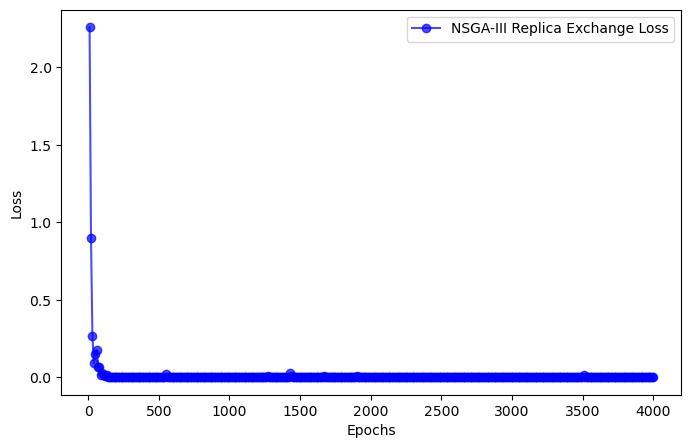

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming loss_history is a list of 4 lists, each with 100 elements
loss_history = np.array(loss_history)  # Convert to numpy array if not already
num_records, num_points = loss_history.shape  # Should be (4, 100)

# Generate x-axis: 100 points per record, spaced over 4000 epochs
epochs = np.linspace(10, 4000, num_points * num_records)  # 100 points * 4 lists

# Flatten loss_history to align with x-axis
loss_values = loss_history.flatten()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b', alpha=0.7, label="NSGA-III Replica Exchange Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")


plt.legend()

plt.show()

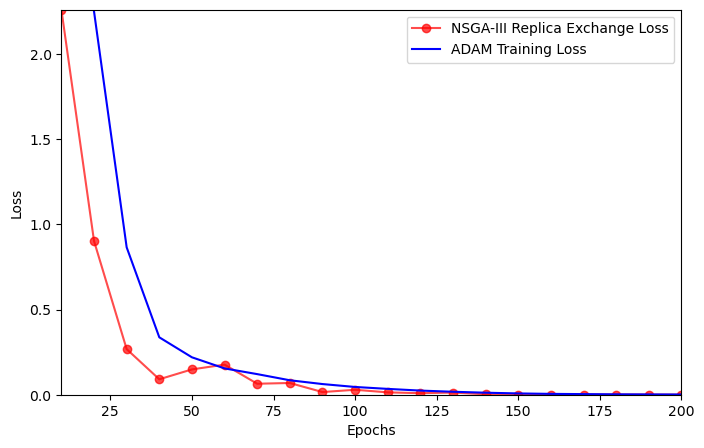

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming loss_history is a list of 4 lists, each with 100 elements
loss_history = np.array(loss_history)  # Convert to numpy array if not already
num_records, num_points = loss_history.shape  # Should be (4, 100)

# Generate x-axis: 100 points per record, spaced over 4000 epochs
epochs = np.linspace(10, 4000, num_points * num_records)  # 100 points * 4 lists

# Flatten loss_history to align with x-axis
loss_values = loss_history.flatten()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='red', alpha=0.7, label="NSGA-III Replica Exchange Loss")
plt.plot(epochs, loss_history_adam[::10], label="ADAM Training Loss", color='blue')
# Zooming in on a specific range of the plot (e.g., first 1000 epochs)
plt.xlim(10, 200)  # Set the x-axis limit from 10 to 1000 epochs
plt.ylim(np.min(loss_values), np.max(loss_values))  # Optional: adjust the y-axis range based on data

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.show()


In [77]:
non_dominated_sorted_solution

[[0, 1, 2, 3]]

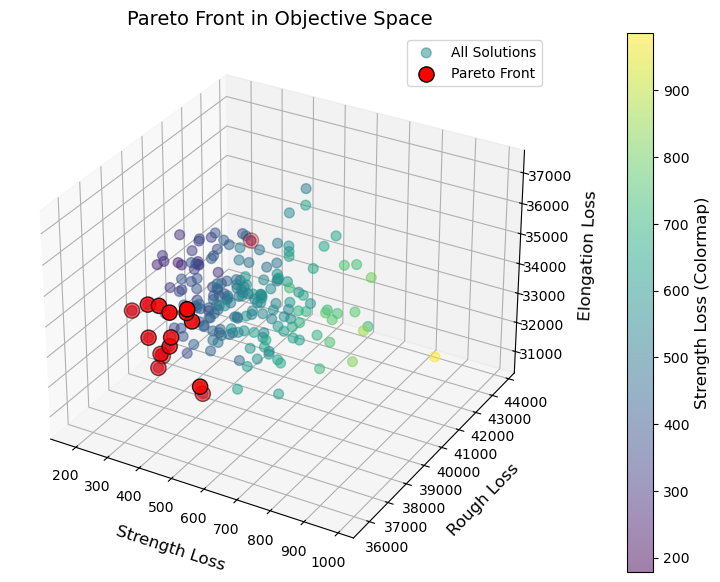

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Population size and generations
pop_size = 200

for i in range (0,pop_size):
  solution.append(DNNRegressor())

# Assume these are your PyTorch tensors
objective1_values = [strength_loss(solution[i]) for i in range(pop_size)]
objective2_values = [rough_loss(solution[i]) for i in range(pop_size)]
objective3_values = [elongation_loss(solution[i]) for i in range(pop_size)]

# Convert tensors to NumPy arrays
objective1_values = np.array([val.detach().numpy() if hasattr(val, 'detach') else val for val in objective1_values])
objective2_values = np.array([val.detach().numpy() if hasattr(val, 'detach') else val for val in objective2_values])
objective3_values = np.array([val.detach().numpy() if hasattr(val, 'detach') else val for val in objective3_values])

# Perform non-dominated sorting
non_dominated_sorted_solution = non_dominated_sorting(objective1_values, objective2_values, objective3_values)

# Extract the first front (Pareto front)
pareto_front_indices = non_dominated_sorted_solution[0]
pareto_objective1 = objective1_values[pareto_front_indices]
pareto_objective2 = objective2_values[pareto_front_indices]
pareto_objective3 = objective3_values[pareto_front_indices]

# Create a figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot **all solutions** with colormap (depth perception)
sc = ax.scatter(objective1_values, objective2_values, objective3_values, 
                c=objective1_values, cmap='viridis', marker='o', s=50, alpha=0.5, label="All Solutions")

# Plot **Pareto front** (red with black edges)
ax.scatter(pareto_objective1, pareto_objective2, pareto_objective3, 
           color='red', marker='o', edgecolors='black', s=120, label="Pareto Front")

# Labels & Title
ax.set_xlabel("Strength Loss", fontsize=12, labelpad=10)
ax.set_ylabel("Rough Loss", fontsize=12, labelpad=10)
ax.set_zlabel("Elongation Loss", fontsize=12, labelpad=10)
ax.set_title("Pareto Front in Objective Space", fontsize=14)

# Legend
ax.legend(loc="best", fontsize=10)

# Add a color bar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label("Strength Loss (Colormap)", fontsize=12)

# Show the interactive plot
plt.show()

In [80]:
non_dominated_sorted_solution 

[[0, 1, 2, 3]]

In [81]:
pareto_objective1

array([ 6517.0483,  6517.0483,  6517.0483, 14529.827 ], dtype=float32)

In [86]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import trange

# Ensure model and train_loader are defined
device = torch.device("cpu")
model = model.to(device)  # Move model to the appropriate device
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
epochs = 4000
best_loss = np.inf
loss_history_adam = []  # Store loss values for plotting
pbar = trange(epochs, desc="Training Progress")  # Keep full epoch count

model.train()
criterion = nn.MSELoss()

for epoch in range(epochs):
    loss_record_epoch = []  # Reset loss record for each epoch
    
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move batch to device
        optimizer.zero_grad()
        y_pred = model(x_batch)

        # Compute separate losses
        loss_0 = criterion(y_pred[:, 0], y_batch[:, 0])
        loss_1 = criterion(y_pred[:, 1], y_batch[:, 1])
        loss_2 = criterion(y_pred[:, 2], y_batch[:, 2])

        # Total loss
        loss = loss_0 + loss_1 + loss_2
        loss.backward()
        optimizer.step()

        loss_record_epoch.append(loss.item())  # Store loss for averaging
    
    # Compute avg_loss_epoch safely
    avg_loss_epoch = sum(loss_record_epoch) / len(loss_record_epoch) if loss_record_epoch else float('inf')
    loss_history_adam.append(avg_loss_epoch)  # Save loss for plotting

    # Track best loss
    if avg_loss_epoch < best_loss:
        best_loss = avg_loss_epoch

    # Update progress bar every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch + 1 == epochs:
        pbar.set_postfix(
            {
                'Epoch': epoch + 1,
                'Train-Loss': avg_loss_epoch,
                'Best-Loss': best_loss,
            }
        )
        pbar.update(10)  # Move progress bar by 10 steps

pbar.close()  # Close progress bar after training


Training Progress: 100%|██████████| 4000/4000 [00:24<00:00, 164.96it/s, Epoch=4000, Train-Loss=1.63e-8, Best-Loss=9.1e-15]  


ValueError: x and y must have same first dimension, but have shapes (4000,) and (4, 100)

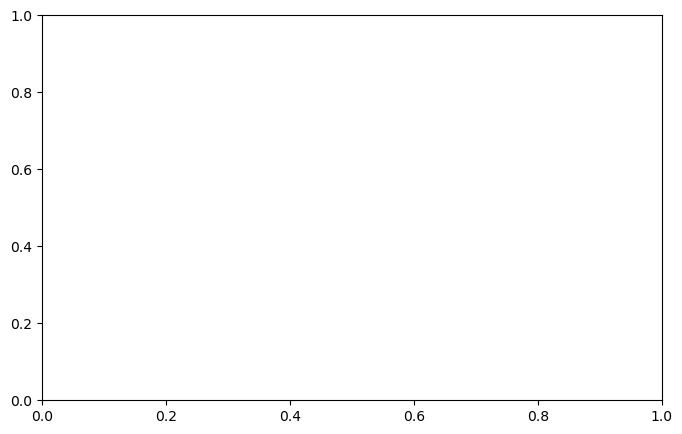

In [87]:
import matplotlib.pyplot as plt

# Assuming loss_history is a list of loss values, and epochs is the total number of epochs
epochs = 4000  # Replace this with the actual number of epochs
loss_history = np.array(loss_history)  # Ensure loss_history is a NumPy array if not already

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_history, label="NSGAIII Replica Exchange Training Loss", color='blue')
plt.plot(range(1, epochs + 1), loss_history_adam, label="ADAM Training Loss", color='blue')

# Zooming in on a specific range (e.g., first 1000 epochs)
plt.xlim(10, 200)  # Set the x-axis limit from 10 to 1000 epochs
plt.ylim(np.min(loss_history), np.max(loss_history))  # Adjust the y-axis to fit the loss range

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()

plt.show()


In [90]:
print(len(loss_history_adam))

4000


In [92]:
print(len(loss_values))

400


In [98]:
len(loss_history_adam[::10])

400